In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as k

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Input, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [53]:
df_test = pd.read_csv('../data/annotation/test_annotation.csv').drop(columns = 'Unnamed: 0')
df_train = pd.read_csv('../data/annotation/train_annotation.csv').drop(columns = 'Unnamed: 0')

In [54]:
df_train['images'] = df_train['Filename'].apply(lambda x: x.split('/')[1])
df_test['images'] = df_test['Filename'].apply(lambda x: x.split('/')[1])

In [55]:
df_train['image_flow'] = df_train['Annotation tag'] + '/' + df_train['images']
df_test['image_flow'] = df_test['Annotation tag'] + '/' + df_test['images']

In [56]:
# create new df_test with no duplicates
df_test_flow = df_test[['Annotation tag','image_flow']]
df_test_flow.drop_duplicates(inplace = True)

/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
df_train['Annotation tag'].value_counts(normalize = True)

go             0.442751
stop           0.354687
stopLeft       0.148709
warning        0.024274
goLeft         0.023849
warningLeft    0.005731
Name: Annotation tag, dtype: float64

In [58]:
df_test['Annotation tag'].value_counts(normalize = True)

stop           0.449895
go             0.412444
stopLeft       0.087200
warning        0.024476
goLeft         0.021509
goForward      0.003556
warningLeft    0.000919
Name: Annotation tag, dtype: float64

## Train/Test Data Structure

In [59]:
train = ImageDataGenerator(         
    width_shift_range = 0.2,      # shift horizontal by 0.2
    height_shift_range = 0.2,     # shift vertical by 0.2
    shear_range = 0.2,
    zoom_range = 0.2,             # zoom in by 0.2
    rescale = 1./255,
    fill_mode = 'nearest'
) 

test = ImageDataGenerator(
    rescale = 1./255
)

In [60]:
# from dataframe (annotation)
# test_generator = test.flow_from_dataframe(
#             dataframe=df_test_flow, 
#             directory="../data/test_eda/", 
#             x_col='image_flow', 
#             y_col= 'Annotation tag', 
#             class_mode="categorical", 
#             target_size=(128,128),     # check docs
#             batch_size= 32    #increase 
# )

In [61]:
# from directory
train_data = train.flow_from_directory(
    '../data/color_train/',
    target_size = (64,64),               # image size __ x __
    batch_size = 64,                       # each model run ___ images
    class_mode = 'binary'
)

test_data = test.flow_from_directory(
    '../data/color_test/',
    target_size = (64,64),
    batch_size = 64,
    class_mode = 'binary'
)

Found 53105 images belonging to 2 classes.
Found 69623 images belonging to 2 classes.


In [62]:
# create class weight
label_count = {}
tags = ['go','stop']

for tag in tags:
    label_count[tag] = len(df_train[df_train['Annotation tag'] == tag])

total_count = sum(label_count.values())

class_weight = {label:total_count/count for label,count in enumerate(label_count.values())}
class_weight

{0: 1.801098230628432, 1: 2.2482863670982485}

In [63]:
batch_size = 64
num_of_test_sample = 69623

## Model

In [66]:
# Model
model = Sequential()

model.add(Conv2D(filters = 40,
                 kernel_size = (4,4),
                 activation = 'relu',
                 input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size = (2,2)))


model.add(Conv2D(40,
                 kernel_size = (5,5),
                 kernel_regularizer = regularizers.l2(0.05),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))



model.add(Flatten())


model.add(Dense(16,
                activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(8,
                activation = 'relu'))
# model.add(Dropout(0.1))

# callbacks
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    restore_best_weights = True
)

rp = ReduceLROnPlateau(factor = 0.01,
                       patience = 2)

callbacks = [es, rp]

# output
model.add(Dense(1,
                activation = 'sigmoid'))


# compile
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.summary()


history = model.fit_generator(train_data,
                              epochs = 10,
                              validation_data = test_data,
                              callbacks = callbacks,
                              class_weight= class_weight,
                              verbose = 1 )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 61, 61, 40)        1960      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 40)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 40)        40040     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 40)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                108176    
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
__________

In [67]:
# get prediction
y_pred_class = model.predict_classes(test_data,
                                     num_of_test_sample // batch_size+1,
                                     verbose = 1)
sum(y_pred_class == 1)

1088/1088 [==============================] - 169s 155ms/step


array([39361])

In [68]:
y_pred_arg_class = np.argmax(y_pred_class, axis = 1)

In [69]:
matrix = confusion_matrix(test_data.classes, y_pred_class)
pd.DataFrame(matrix, columns= ['actual go', 'actual stop'], index=['predicted go','predicted stop'])

,actual go,actual stop
predicted go,13006,16917
predicted stop,17256,22444


In [70]:
# classification report
report = classification_report(test_data.classes, y_pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.43      0.43      0.43     29923
           1       0.57      0.57      0.57     39700

    accuracy                           0.51     69623
   macro avg       0.50      0.50      0.50     69623
weighted avg       0.51      0.51      0.51     69623



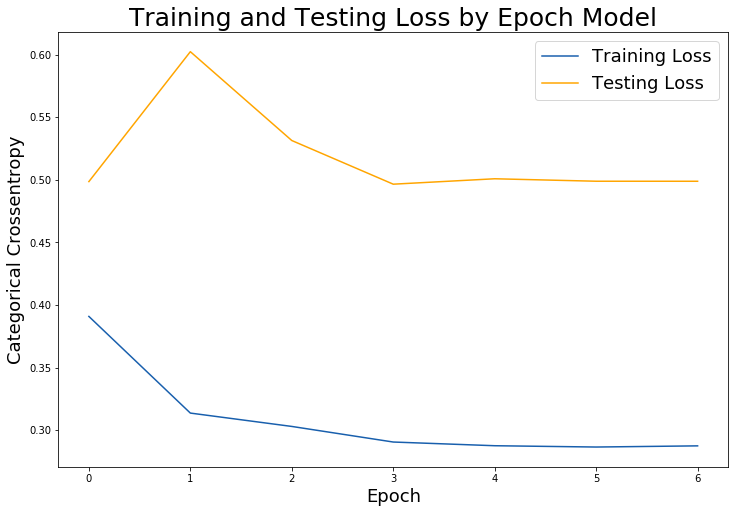

In [71]:
# loss visualization
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch Model', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
# plt.xticks(np.arange(10), np.arange(10))
#plt.ylim((0, 1)) 
plt.legend(fontsize = 18);

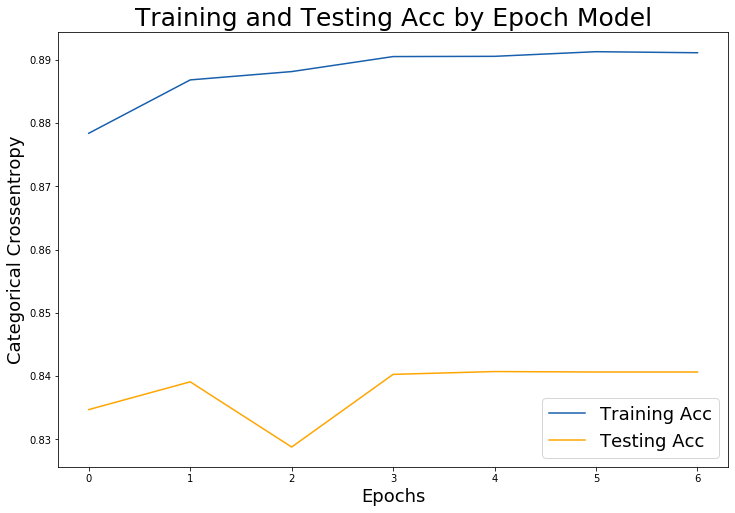

In [72]:
# accuracy visualization
train_acc = history.history['acc']
test_acc = history.history['val_acc']
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Acc', color='#185fad')
plt.plot(test_acc, label='Testing Acc', color='orange')
plt.title('Training and Testing Acc by Epoch Model', fontsize = 25)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
# plt.xticks(np.arange(10), np.arange(10))
#plt.ylim((0, 1))
plt.legend(fontsize = 18);

In [73]:
# value for test loss and accuracy
score = model.evaluate(test_data,
                       verbose=1)

labels = model.metrics_names

print(labels[0], score[0])
print(labels[1], score[1])

1088/1088 [==============================] - 168s 154ms/step - loss: 0.4965 - acc: 0.8403
loss 0.49650942052111907
acc 0.8402683


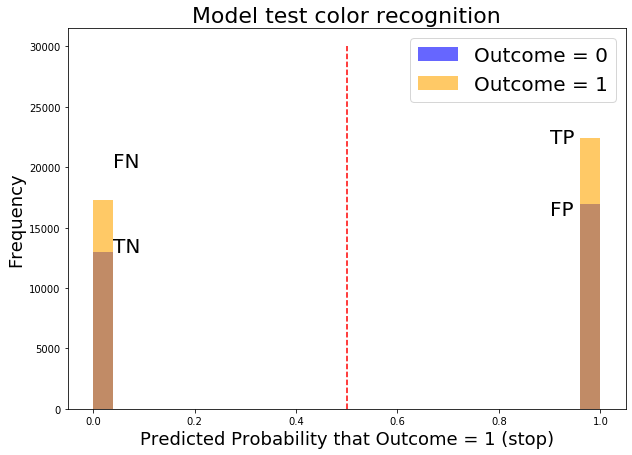

In [74]:
# distribution of outcome

pred_proba_df = pd.DataFrame({
    'true' : test_data.classes,
    'pred_prob' : y_pred_class.flatten()
})

# Adapt from notes Classification Metrics II

# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_proba_df[pred_proba_df['true'] == 0]['pred_prob'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_proba_df[pred_proba_df['true'] == 1]['pred_prob'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 30000,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 20000),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.04, 13000),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.9, 16000),
             s = 'FP',
             size = 20)

plt.annotate(xy = (0.9, 22000),
             s = 'TP',
             size = 20)

# Label axes.
plt.title('Model test color recognition', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1 (stop)', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);